# Introduction

This Jupyter notebook demonstrates a simple neural network implemented in PyTorch
for regression tasks using a dataset loaded from a CSV file, which was heart failure data after PCA implementation.


In [1]:

# Imports
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


## Data Loading and Inspection

In this section, we load the dataset from a CSV file and inspect the data to understand its structure and characteristics.


In [2]:
# Load CSV data
data_path = './Data/pca_output.csv'
data = pd.read_csv(data_path)

# Inspect data
print(data.head())
print(data.describe())
print(data.dtypes)


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.955159 -1.560260  0.097974  0.896793  0.700994 -0.245900  0.867275   
1 -0.770247  1.315624 -1.927614 -2.148217 -0.907282  1.481883  0.116760   
2 -1.908705 -0.592362  1.159538  2.901140 -1.311335 -0.191523 -0.039797   
3  2.000908  0.703153 -3.283777  0.089905  0.117482  0.185970 -0.285569   
4 -1.913519 -1.106466  0.781337 -1.146080 -0.739537  1.529513 -0.887756   

        PC8  
0 -0.856372  
1  0.562671  
2  0.234949  
3  0.713701  
4 -0.800937  
                PC1           PC2           PC3         PC4           PC5  \
count  7.460000e+02  7.460000e+02  7.460000e+02  746.000000  7.460000e+02   
mean   7.619761e-17  7.619761e-17  7.619761e-17    0.000000  1.904940e-17   
std    2.305208e+00  1.421294e+00  1.353029e+00    1.193318  1.151826e+00   
min   -4.147973e+00 -2.339167e+00 -3.660851e+00   -2.910956 -3.582033e+00   
25%   -2.119389e+00 -1.289077e+00 -9.954078e-01   -0.778808 -6.493432e-01   
50%

## Data Preprocessing

Next, we preprocess the data. This includes:
1. Identifying target and feature columns.
2. One-hot encoding categorical features.
3. Standardizing numerical features.
4. Splitting the data into training and testing sets.
5. Converting the data into PyTorch tensors.


In [3]:
# Assuming the last column is the target and others are features
target_column = data.columns[-1]
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
numerical_columns.remove(target_column)

# One-Hot Encode categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical_data = encoder.fit_transform(data[categorical_columns])

# Concatenate numerical and encoded categorical data
X = pd.concat([data[numerical_columns], pd.DataFrame(encoded_categorical_data)], axis=1).values
y = data[target_column].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


## Creating Datasets and DataLoaders

We create PyTorch datasets and dataloaders for batch processing. This helps in efficiently feeding data to the neural network during training.


In [4]:
# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Defining the Neural Network

Here, we define a simple neural network class in PyTorch. This neural network consists of three fully connected layers with ReLU activation functions.


In [5]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = SimpleNN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Training the Neural Network

In this section, we train the neural network. We define the training loop, specify the loss function, and use the Adam optimizer. We also record the training and testing losses at each epoch.


In [6]:
# Training loop with recording losses
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}')


Epoch 1/50, Train Loss: 0.9977294363473591, Test Loss: 1.3319382548332215
Epoch 2/50, Train Loss: 0.9263096200792413, Test Loss: 1.2945844650268554
Epoch 3/50, Train Loss: 0.8837851317305314, Test Loss: 1.2485060811042785
Epoch 4/50, Train Loss: 0.8104926316361678, Test Loss: 1.2015039205551148
Epoch 5/50, Train Loss: 0.7449874689704493, Test Loss: 1.1604058027267456
Epoch 6/50, Train Loss: 0.6543619091573515, Test Loss: 1.1051600217819213
Epoch 7/50, Train Loss: 0.6006276764367756, Test Loss: 1.062079918384552
Epoch 8/50, Train Loss: 0.5274628839994732, Test Loss: 1.0187096118927002
Epoch 9/50, Train Loss: 0.4789176222525145, Test Loss: 1.000623631477356
Epoch 10/50, Train Loss: 0.44920054705519424, Test Loss: 0.9755876898765564
Epoch 11/50, Train Loss: 0.4098478587050187, Test Loss: 0.9446150481700897
Epoch 12/50, Train Loss: 0.3912822941416188, Test Loss: 0.9310940861701965
Epoch 13/50, Train Loss: 0.3627033217957145, Test Loss: 0.9096498429775238
Epoch 14/50, Train Loss: 0.34847219

## Evaluating and Plotting Results

Finally, we evaluate the neural network by plotting the training and validation losses over epochs to visualize the model's performance.


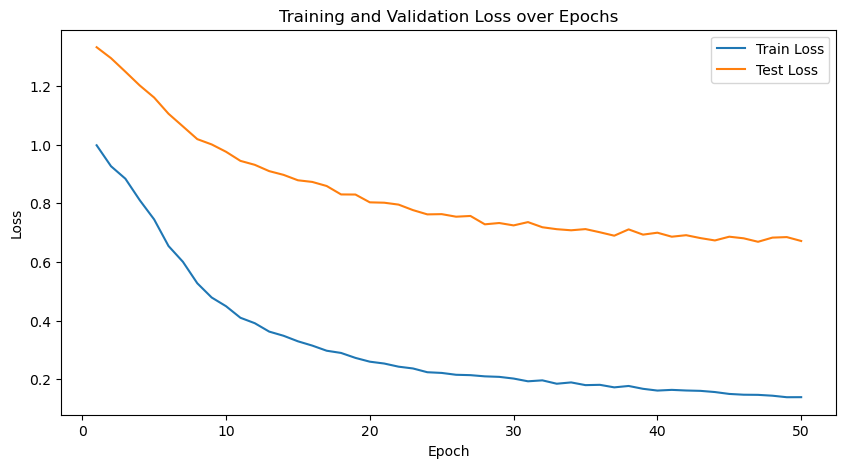

In [7]:
# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()
